<a href="https://colab.research.google.com/github/thisissepehr/image-classification-deep-models/blob/main/VGG16_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import time
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import cv2

from torchvision import datasets
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchsummary import summary


1.11.0+cu113


In [2]:
# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Architecture
NUM_CLASSES = 10

# Other

DEVICE = 'cuda:0'
# print(DEVICE)
GRAYSCALE = False

In [3]:
import torchvision
transform_train = transforms.Compose([
    # transforms.RandomRotation(30),
    transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    ])


train_ds = datasets.CIFAR10(root='data', 
                               train=True, 
                               transform=transform_train,
                               download=True)
train_set, val_set = torch.utils.data.random_split(train_ds, [45000, 5000])

test_ds = datasets.CIFAR10(root='data', 
                              train=False, 
                              transform=transform_test)


train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                      shuffle = True)


val_loader = DataLoader(dataset=val_set,
                          batch_size=BATCH_SIZE,
                      shuffle = False)

test_loader = DataLoader(dataset=test_ds,
                     batch_size=BATCH_SIZE,
                     shuffle = False)

# Checking the dataset
images, labels = next(iter(train_loader))  
print('Image batch dimensions:', images.shape)
print('Image label dimensions:', labels.shape)

Files already downloaded and verified
Image batch dimensions: torch.Size([32, 3, 32, 32])
Image label dimensions: torch.Size([32])


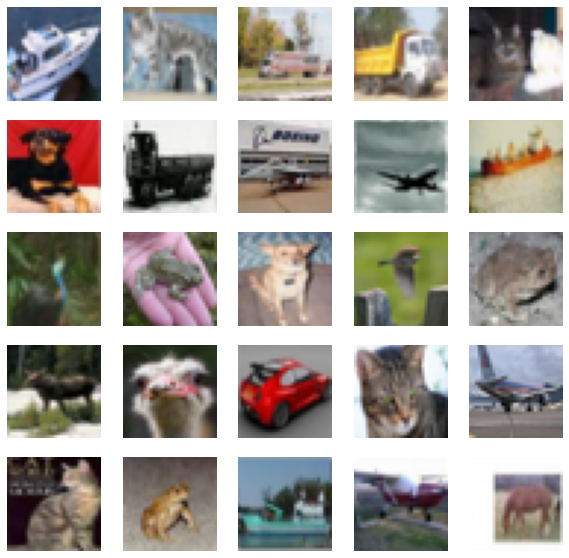

In [4]:
features, targets = next(iter(train_loader))
features = features
targets = targets
fig, ax = plt.subplots(5,5, figsize=(10,10))
for index in range(25):
    nhwc_img = np.transpose(features[index], axes=(1, 2, 0))
    ax[index//5][index%5].imshow(nhwc_img, cmap='Greys')
    ax[index//5][index%5].axis('off')
    


In [5]:
#Model
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name,in_channels): #in channels determine if the images are RGB or Grayscale
        height, width = 3, 3
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, NUM_CLASSES)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(x)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
torch.manual_seed(RANDOM_SEED)

In [6]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_predictions, counter = 0, 0
        for _, (img, label) in enumerate(data_loader):
            img = img.to(device)
            label = label.float().to(device)
            logits = model(img)
            _, predicted_label = torch.max(logits, 1)
            counter += label.size(0)
            correct_predictions += (predicted_label == label).sum()
    return correct_predictions.float()/counter * 100


In [7]:
def init_weights(m):
    if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            m.bias.detach().zero_()
            

In [19]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = VGG("VGG16",3)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.apply(init_weights)
model = model.to(DEVICE)
summary(model,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,584
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
        MaxPool2d-14            [-1, 12

In [20]:
def train(model, num_epochs, train_loader,valid_loader, test_loader, optimizer):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            train_acc = accuracy(model, train_loader, device=DEVICE)
            valid_acc = accuracy(model, valid_loader, device=DEVICE)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')        
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')
    test_acc = accuracy(model, test_loader, device=DEVICE)
    print(f'Test accuracy {test_acc :.2f}%')

In [21]:
train(model= model,
      num_epochs = NUM_EPOCHS,
      train_loader= train_loader,
      valid_loader = val_loader,
      test_loader = test_loader,
      optimizer = optimizer)

  0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 001/010 | Train: 61.45% | Validation: 60.22%
Time elapsed: 0.59 min


  0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 002/010 | Train: 76.82% | Validation: 73.72%
Time elapsed: 1.17 min


  0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 003/010 | Train: 83.95% | Validation: 78.34%
Time elapsed: 1.76 min


  0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 004/010 | Train: 86.73% | Validation: 79.62%
Time elapsed: 2.35 min


  0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 005/010 | Train: 90.25% | Validation: 82.18%
Time elapsed: 2.93 min


  0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 006/010 | Train: 90.98% | Validation: 80.20%
Time elapsed: 3.52 min


  0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 007/010 | Train: 95.98% | Validation: 84.02%
Time elapsed: 4.11 min


  0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 008/010 | Train: 95.86% | Validation: 82.80%
Time elapsed: 4.69 min


  0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 009/010 | Train: 97.31% | Validation: 83.74%
Time elapsed: 5.28 min


  0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 010/010 | Train: 95.62% | Validation: 81.42%
Time elapsed: 5.86 min
Total Training Time: 5.86 min
Test accuracy 82.26%


In [22]:
def get_prediction(x, model):
    model.to('cpu') # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [23]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_loader), total=len(test_loader)):
    x, y = batch
    true_y.extend(y)
    preds, probs = get_prediction(x, model)
    pred_y.extend(preds.cpu())

  0%|          | 0/313 [00:00<?, ?it/s]

In [24]:
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.838     0.848     0.843      1000
           1      0.911     0.896     0.903      1000
           2      0.824     0.702     0.758      1000
           3      0.679     0.693     0.686      1000
           4      0.765     0.839     0.800      1000
           5      0.721     0.813     0.764      1000
           6      0.817     0.860     0.838      1000
           7      0.919     0.785     0.847      1000
           8      0.909     0.895     0.902      1000
           9      0.880     0.895     0.887      1000

    accuracy                          0.823     10000
   macro avg      0.826     0.823     0.823     10000
weighted avg      0.826     0.823     0.823     10000



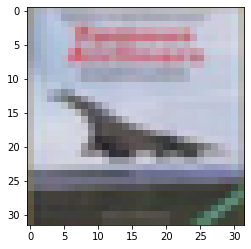

In [25]:
features, targets = next(iter(test_loader))    
nhwc_img = np.transpose(features[3], axes=(1, 2, 0))
# nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhwc_img, cmap='Greys')

In [26]:
predicted, probability = get_prediction(features[3, None], model)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print('Predicted: {}'.format(classes[predicted[0]]), predicted, )
print('Probability:', probability[0][predicted]*100)

Predicted: airplane tensor([0])
Probability: tensor([99.0298], grad_fn=<MulBackward0>)


In [27]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    fig, ax = plt.subplots(figsize=(16,16))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[848  10  24  24  17   3  14   2  32  26]
 [ 13 896   2   2   1   2   6   0  18  60]
 [ 51   1 702  42  61  45  71  17   7   3]
 [  8   3  46 693  41 149  30  18   6   6]
 [  6   2  18  53 839  37  31  10   4   0]
 [  7   2  30  82  23 813  21  15   4   3]
 [  5   2  11  72  23  15 860   3   9   0]
 [ 14   4  10  24  88  60   8 785   1   6]
 [ 43  13   5  16   2   1   6   1 895  18]
 [ 17  51   4  12   2   2   5   3   9 895]]


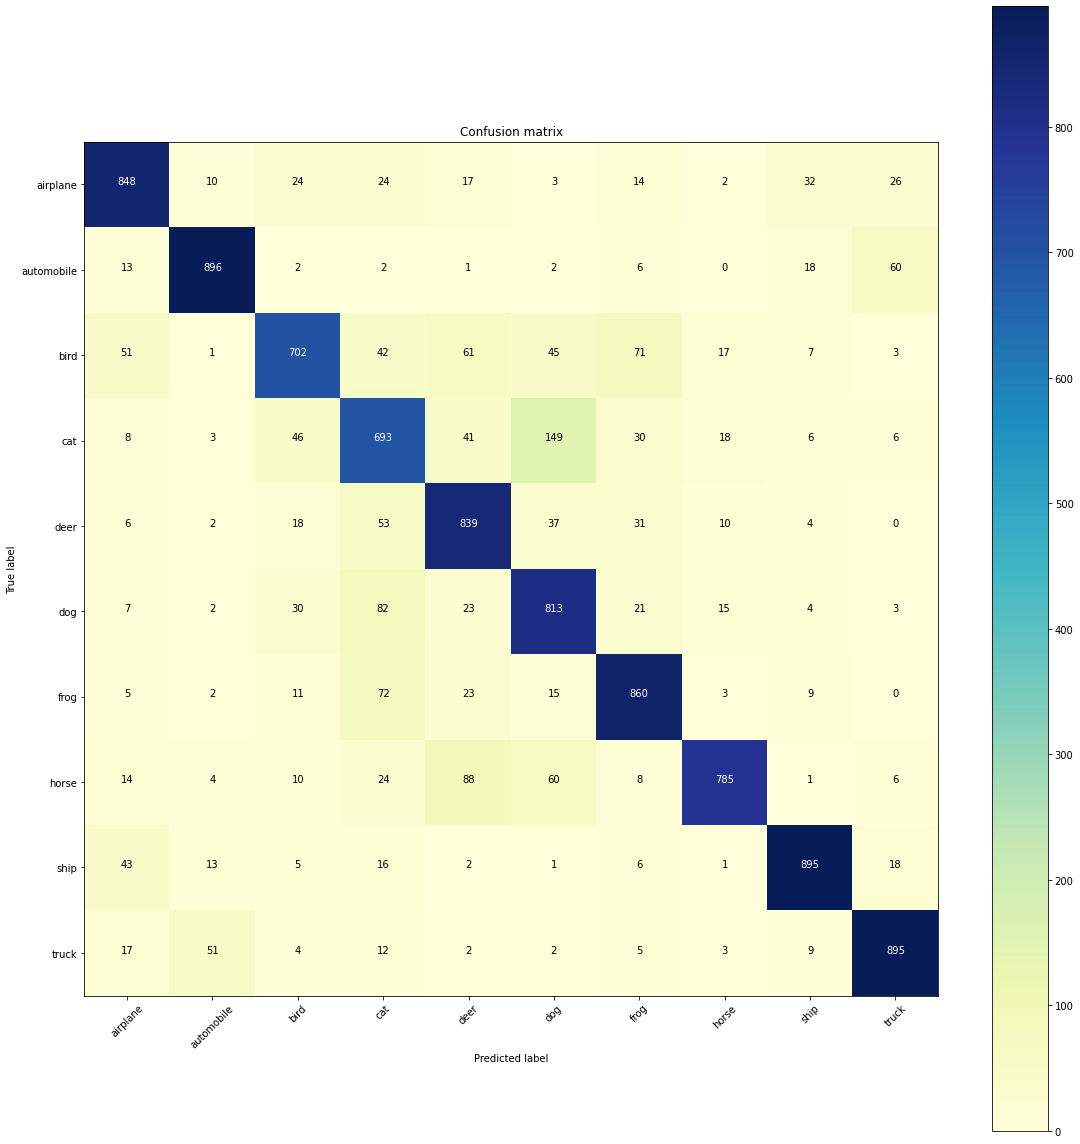

In [28]:
cm = confusion_matrix(true_y, pred_y)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cm,labels) 